In [1]:
#本章需导入的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings(action = 'ignore')
from sklearn.metrics import confusion_matrix,f1_score,roc_curve, auc, precision_recall_curve,accuracy_score
from sklearn.model_selection import train_test_split,KFold,LeaveOneOut,LeavePOut # 数据集划分方法
from sklearn.model_selection import cross_val_score,cross_validate # 计算交叉验证下的测试误差
from sklearn import preprocessing
import sklearn.linear_model as LM
from sklearn import neighbors

有无污染
0    1204
1     892
Name: count, dtype: int64
截距项:-4.858433
回归系数: [[0.05260359 0.01852684]]
优势比[[1.05401174 1.01869953]]
预测结果： [0 1 0 ... 0 0 0]
总的错判率：0.153149


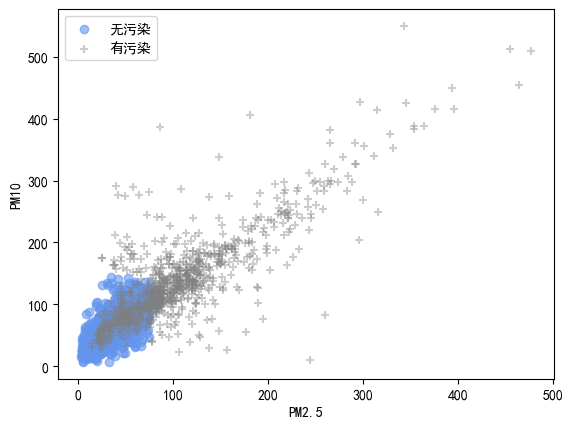

In [3]:
data=pd.read_excel('北京市空气质量数据.xlsx')
data=data.replace(0,np.nan)
data=data.dropna()
data['有无污染']=data['质量等级'].map({'优':0,'良':0,'轻度污染':1,'中度污染':1,'重度污染':1,'严重污染':1})
print(data['有无污染'].value_counts())

fig = plt.figure()
ax = fig.add_subplot(111)
flag=(data['有无污染']==0)
ax.scatter(data.loc[flag,'PM2.5'],data.loc[flag,'PM10'],c='cornflowerblue',marker='o',label='无污染',alpha=0.6)
flag=data['有无污染']==1
ax.scatter(data.loc[flag,'PM2.5'],data.loc[flag,'PM10'],c='grey',marker='+',label='有污染',alpha=0.4)
ax.set_xlabel('PM2.5')
ax.set_ylabel('PM10')
plt.legend()

##Logistic回归
X=data[['PM2.5','PM10']]
y=data['有无污染']
modelLR=LM.LogisticRegression()
modelLR.fit(X,y)
print("截距项:%f"%modelLR.intercept_)
print("回归系数:",modelLR.coef_)
print("优势比{0}".format(np.exp(modelLR.coef_)))
yhat=modelLR.predict(X)
print("预测结果：",yhat)
print("总的错判率：%f"%(1-modelLR.score(X,y)))


说明：
1、这里以空气质量监测数据为例，对是否有污染（二分类输出变量）进行预测。首先对数据进行预处理，将质量等级是优和良的合并为0类（无污染）共计1204天。其余合并为1类（有污染）共计892天。这里只考虑PM2.5和PM10对有无污染的影响，作为输入变量，只有0和1两个取值的有无污染作为输出变量。建立Logistic回归模型。
2、首先，modelLR=LM.LogisticRegression()定义modelLR对象为Logistic回归模型；然后，modelLR.fit(X,y)表示基于给出的X和y估计模型参数。其中，X为输入变量（矩阵形式），y为输出变量。
3、模型参数的估计值存储在intercept_和.coef_属性中，依次为截距项和回归系数。从回归系数估计值看，PM2.5（系数为0.05）对是否有污染的作用比PM10（系数为0.02）更大。
4、modelLR.predict(X)表示将X带入回归方程计算y的预测值。


训练误差: 0.0782442748091603
混淆矩阵:
 [[1128   76]
 [  88  804]]
F1-score: 0.90744920993228
AUC: 0.982303010890455
总正确率 0.9217557251908397


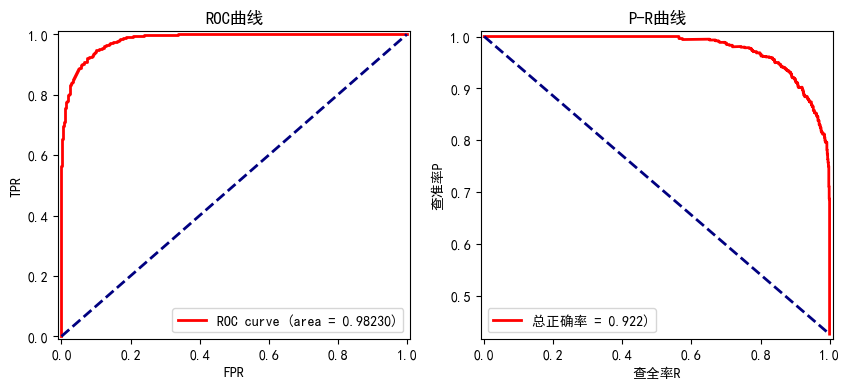

In [5]:
X=data.loc[:,['PM2.5','PM10','SO2','CO','NO2','O3']]
Y=data.loc[:,'有无污染']
modelLR=LM.LogisticRegression()
modelLR.fit(X,Y)
print('训练误差:',1-modelLR.score(X,Y))  #print(accuracy_score(Y,modelLR.predict(X)))
print('混淆矩阵:\n',confusion_matrix(Y,modelLR.predict(X)))
print('F1-score:',f1_score(Y,modelLR.predict(X),pos_label=1))
fpr,tpr,thresholds = roc_curve(Y,modelLR.predict_proba(X)[:,1],pos_label=1) ###计算fpr和tpr
roc_auc = auc(fpr,tpr) ###计算auc的值
print('AUC:',roc_auc)
print('总正确率',accuracy_score(Y,modelLR.predict(X)))
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,4))
axes[0].plot(fpr, tpr, color='r',linewidth=2, label='ROC curve (area = %0.5f)' % roc_auc) 
axes[0].plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--')
axes[0].set_xlim([-0.01, 1.01])
axes[0].set_ylim([-0.01, 1.01])
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_title('ROC曲线')
axes[0].legend(loc="lower right")

pre, rec, thresholds = precision_recall_curve(Y,modelLR.predict_proba(X)[:,1],pos_label=1)
axes[1].plot(rec, pre, color='r',linewidth=2, label='总正确率 = %0.3f)' % accuracy_score(Y,modelLR.predict(X))) 
axes[1].plot([0,1],[1,pre.min()],color='navy', linewidth=2, linestyle='--')
axes[1].set_xlim([-0.01, 1.01])
axes[1].set_ylim([pre.min()-0.01, 1.01])
axes[1].set_xlabel('查全率R')
axes[1].set_ylabel('查准率P')
axes[1].set_title('P-R曲线')
axes[1].legend(loc='lower left')
plt.show()

说明： 1、这里利用空气质量监测数据，建立Logistic回归模型对是否有污染进行分类预测。其中的输入变量包括PM2.5,PM10,SO2,CO,NO2,O3污染物浓度，是否有污染为二分类的输出变量（1为有污染，0为无污染）。进一步，对模型进行评价，涉及ROC曲线、AUC值以及F1分数等。需引用sklearn.metrics中的confusion_matrix,f1_score,roc_curve, auc，以及import accuracy_score等。 2、modelLR.score(X,Y)为预测模型的精度得分（基于训练集的）。分类预测的精度得分为总的预测正确率。也可通过accuracy_score函数得到同样结果。 3、confusion_matrix(Y,modelLR.predict(X))：计算模型的混淆矩阵。 4、f1_score(Y,modelLR.predict(X),pos_label=1)：针对1类计算F1得分。 5、modelLR.predict_proba(X)中存储模型预测为0类和1类的概率，这里关心预测为1类的概率。 6、roc_curve：计算预测为1类的概率从大到小过程中的TPR和FPR。auc(fpr,tpr) 计算ROC曲线下的面积。 7、precision_recall_curve：计算预测为1类的概率从大到小过程中的查准率P和查全率R. 8、ROC曲线和AUC值，以及P-R曲线均表明，该预测模型的预测误差（训练误差）很小。